## Домашнее задание

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [1]:
import numpy as np
import pandas as pd

#### подгружаем датасет. разделитель - ','

In [188]:
data = pd.read_csv('data.csv', ',')
data.head(4)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0


#### Переименовать поля (conversion -> target, offer -> treatment)

In [189]:
data = data.rename(columns={'conversion': 'target', 'offer': 'treatment'})
data.head(4)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0


#### привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [190]:
data['treatment'] = data['treatment'].apply(lambda x: 0 if x == 'No Offer' else 1)
data['treatment']

0        1
1        0
2        1
3        1
4        1
        ..
63995    1
63996    1
63997    1
63998    1
63999    1
Name: treatment, Length: 64000, dtype: int64

In [191]:
data['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

#### сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

для начала хочу категориальный столбей zip_code разложить на три бинарных. 

In [193]:
pd.get_dummies(data['zip_code'])

,Rural,Surburban,Urban
0,0,1,0
1,1,0,0
2,0,1,0
3,1,0,0
4,0,0,1
...,...,...,...
63995,0,0,1
63996,0,0,1
63997,0,0,1
63998,0,1,0


In [194]:
data1 = pd.get_dummies(data['zip_code'])

In [195]:
data['rural'] = data1['Rural']
data['surburban'] = data1['Surburban']
data['urban'] = data1['Urban']

In [196]:
data.drop('zip_code',
  axis='columns', inplace=True)

In [197]:
data

,recency,history,used_discount,used_bogo,is_referral,channel,treatment,target,rural,surburban,urban
0,10,142.44,1,0,0,Phone,1,0,0,1,0
1,6,329.08,1,1,1,Web,0,0,1,0,0
2,7,180.65,0,1,1,Web,1,0,0,1,0
3,9,675.83,1,0,1,Web,1,0,1,0,0
4,2,45.34,1,0,0,Web,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,0,Web,1,0,0,0,1
63996,5,38.91,0,1,1,Phone,1,0,0,0,1
63997,6,29.99,1,0,1,Phone,1,0,0,0,1
63998,1,552.94,1,0,1,Multichannel,1,0,0,1,0


In [198]:
data['recency'].unique()

array([10,  6,  7,  9,  2,  1,  5,  4,  3, 11, 12,  8], dtype=int64)

Значения в столбце recency можно раскидать по четырем бинам: (1-3), (4-6), (7-9), (10-12). Исходный стоблец оставлю, так как не знаю какой из столбцов будет учше коррелировать с целевой переменной. 

In [199]:
bins = [0, 3, 6, 9, 12]
groups = ['1', '2', '3', '4']

data['recency_bin_cut'] = pd.cut(data['recency'], bins=bins, labels=groups)

столбец channel тоже раскидаю на бинарные

In [200]:
data1 = pd.get_dummies(data['channel'])

In [201]:
data['multichannel'] = data1['Multichannel']
data['phone'] = data1['Phone']
data['web'] = data1['Web']

In [202]:
data.drop('channel',
  axis='columns', inplace=True)

In [203]:
data

,recency,history,used_discount,used_bogo,is_referral,treatment,target,rural,surburban,urban,recency_bin_cut,multichannel,phone,web
0,10,142.44,1,0,0,1,0,0,1,0,4,0,1,0
1,6,329.08,1,1,1,0,0,1,0,0,2,0,0,1
2,7,180.65,0,1,1,1,0,0,1,0,3,0,0,1
3,9,675.83,1,0,1,1,0,1,0,0,3,0,0,1
4,2,45.34,1,0,0,1,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,0,1,0,0,0,1,4,0,0,1
63996,5,38.91,0,1,1,1,0,0,0,1,2,0,1,0
63997,6,29.99,1,0,1,1,0,0,0,1,2,0,1,0
63998,1,552.94,1,0,1,1,0,0,1,0,1,1,0,0


#### сделать разбиение набора данных не тренировочную и тестовую выборки

In [205]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1), data['target'], random_state = 0)

### провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

In [206]:
treat_train = X_train['treatment']
treat_test = X_test['treatment']

cat_features = ['recency_bin_cut']

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@30%': []
}

### модель с признаком коммуникации (S learner)

In [207]:
pip install scikit-uplift

Note: you may need to restart the kernel to use updated packages.


In [208]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

In [143]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [144]:
from catboost import CatBoostClassifier

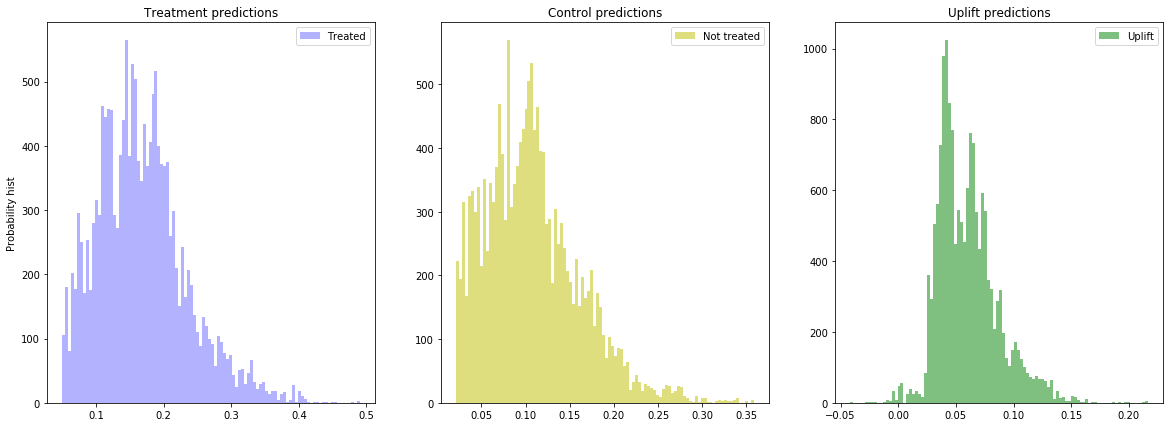

In [209]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@30%'].append(sm_score_30)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

### Топ признаки

In [210]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,treatment,18.965365
1,is_referral,18.398068
2,recency,13.840806
3,used_bogo,13.696475
4,history,9.041118
5,used_discount,8.686397
6,rural,7.726577
7,phone,2.711710
8,web,2.230279
9,recency_bin_cut,1.866934


с разбиением параметра recency на бины промахнулся - особого результата нет

### модель с трансформацией таргета (трансформация классов п. 2. 1)

In [211]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@30%'].append(ct_score_30)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  """


### вариант с двумя независимыми моделями

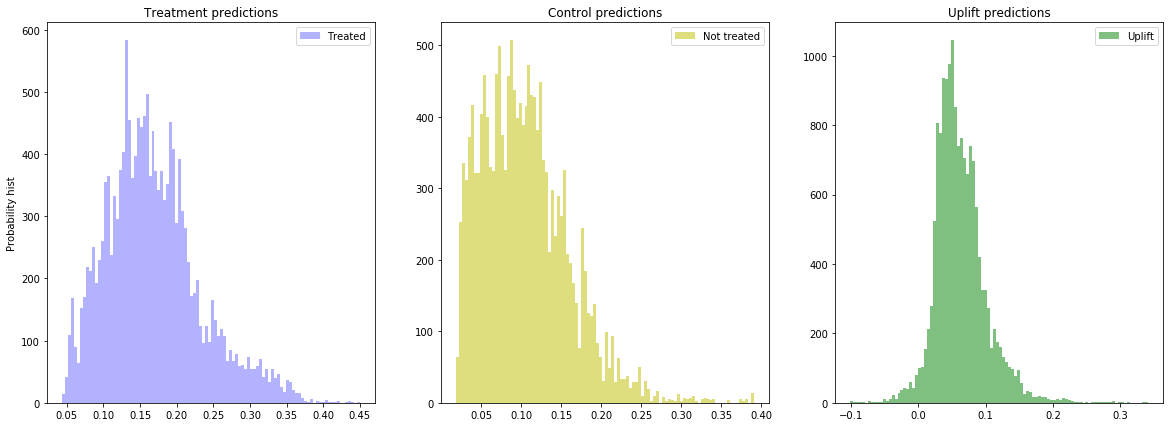

In [212]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@30%'].append(tm_score_30)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

### В конце вывести единую таблицу сравнения метрик uplift@10%, uplift@30% этих 3 моделей

In [213]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False).set_index('approach')

,uplift@10%,uplift@30%
approach,,
ClassTransformation,0.235883,0.170581
SoloModel,0.054436,0.059904
TwoModels,0.052834,0.057471


### построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [214]:
X_train_tree = pd.concat([X_train.drop('recency_bin_cut', 1), 
                          pd.get_dummies(X_train['recency_bin_cut'], prefix='recency_bin_cut')], 1)
features = [col for col in X_train_tree]

In [217]:
python setup.py build_ext --inplace

SyntaxError: invalid syntax (<ipython-input-217-2cb21d7d2b68>, line 1)

In [219]:
pip install causalml

^C
Note: you may need to restart the kernel to use updated packages.


In [220]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


Wall time: 26.5 s


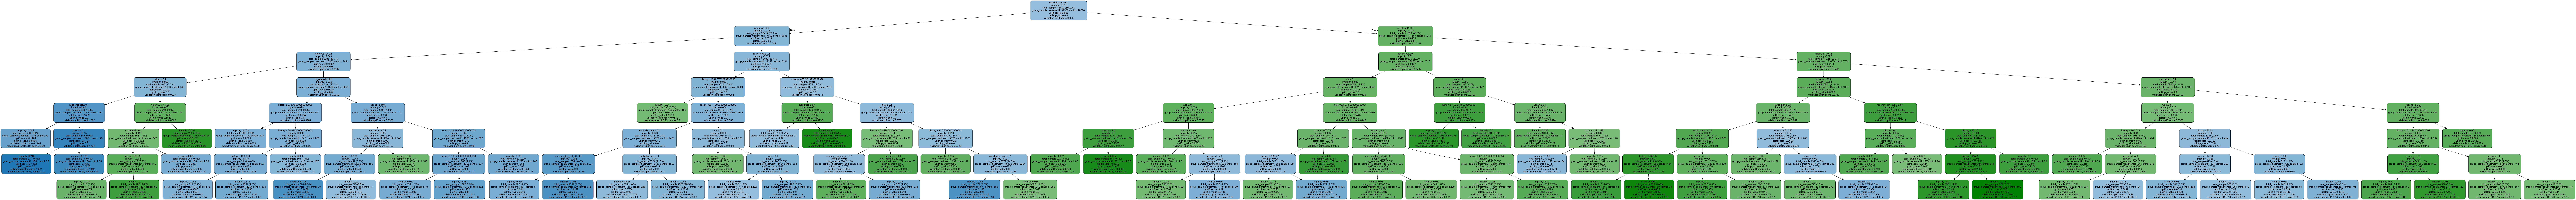

In [221]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())